# **Análisis del dataset de las campañas de comercialización de los bancos**

### **Resumen**

Es un dataset que describen los resultados de las campañas de marketing del banco de Portugal. Las campañas realizadas se basaban principalmente en llamadas telefónicas directas, ofreciendo a los clientes del banco la posibilidad de hacer un depósito a plazo. Si después de todos los esfuerzos de marcado el cliente había aceptado hacer el depósito - la variable objetivo marcaba "sí", de lo contrario "no".

Fuente de datos: https://archive.ics.uci.edu/ml/datasets/bank+marketing


**Citación:**

Este dataset está disponible públicamente para la investigación. Los detalles se describen en S. Moro, P. Cortez and P. Rita. "A Data-Driven Approach to Predict the Success of Bank Telemarketing." Decision Support Systems, Elsevier, 62:22-31, June 2014 

#### **Objetivo**

* Predecir los resultados futuros de las empresas de comercialización en base a las estadísticas disponibles y, en consecuencia, formular recomendaciones para dichas empresas en el futuro.
* Construir un perfil de un consumidor de servicios bancarios (depósitos).

#### **Metodología**

Para completar el objetivo se realizarán las siguientes secciones de tareas que se detallan en el script:
1. Cargar los datos y previsualizarlos. División de registros en conjunto de entrenamiento y de prueba
2. Análisis Exploratorio de los Datos (AED) 

3. Preprocesamiento de los datos. 

4. Procesamiento

5. Modelamiento 

 > ****** usamos intencionalmente la mayoría de los modelos de Machine Learning para aumentar el nivel de interpretación de la solución

##### **Fuentes**

Las fuentes y notebooks consultados han sido las siguientes: 

[1] https://github.com/RumanaSk/Bank-Marketting-Campaign-Analysis/blob/master/NOTEBOOK.ipynb

[2] https://www.kaggle.com/volodymyrgavrysh/bank-marketing-campaigns-dataset-analysis

[3] https://github.com/Ktk25/Bank-Marketing-Campaign-Assignment---UpGrad/blob/master/Bank%20Marketing%20Campaign%20Assignment%20-%20UpGrad.ipynb

[4] https://github.com/systemoperator/ml-project/blob/571149af797783354d29a3f2d2423e60a7561fe7/notebooks/1-cleaning.ipynb

[5] https://github.com/search?l=Jupyter+Notebook&p=7&q=bank-additional-full.csv&type=Code


![Lista de variables del conjunto de datos:](https://Lista de Variables.jpg)

## **1era Sección: Descargar base de datos, visualización de registros y división en conjunto de entrenamiento y de prueba**


In [ ]:
#Descargamos el archivo del dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2020-07-06 04:58:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   679KB/s    in 0.6s    

2020-07-06 04:58:14 (679 KB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/.

In [ ]:
#cargamos las librerías y paquetes que vamos a utilizar
import warnings
warnings.filterwarnings("ignore")
#evitamos los warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn import datasets

pd.set_option("display.max_columns", 50)

%matplotlib inline


' Citando librerias\nscikit-learn\nauthors={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.\n         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.\n         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and\n         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.}\n\n category Encoders\n author = Will McGinnis\n \n matplotlib\n author = Hunter, J. D.\n \n seaborn\n author = Michael Waskom\n\n'

# Cargar Data

In [ ]:
train_url = './bank-additional/bank-additional-full.csv'
dataset = pd.read_csv(train_url, delimiter=";")
#Trabajamos con el dataset completo

display(dataset.head(5))
print('\n Hay {} observaciones con {} características'.format(*dataset.shape))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



 Hay 41188 observaciones con 21 características


In [ ]:
#Dividimos el dataset en un conjunto de entranmiento y un conjunto de prueba (25%)
dataset_train, dataset_test= train_test_split(dataset, test_size=0.25, random_state=0)


In [ ]:
display(dataset_train.head(5))
print('\n Hay {} observaciones con {} características'.format(*dataset_train.shape))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
10685,52,blue-collar,divorced,high.school,no,no,no,telephone,jun,tue,676,2,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,yes
224,40,technician,married,basic.9y,no,no,no,telephone,may,mon,168,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
29638,28,self-employed,single,university.degree,no,yes,no,cellular,apr,mon,187,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
4804,52,technician,married,high.school,unknown,no,no,telephone,may,wed,68,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
11614,35,blue-collar,single,basic.6y,no,no,no,telephone,jun,fri,81,2,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no



 Hay 30891 observaciones con 21 características


In [ ]:
display(dataset_test.head(5))
print('\n Hay {} observaciones con {} características'.format(*dataset_test.shape))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
15500,39,blue-collar,married,basic.9y,no,yes,no,cellular,jul,fri,635,3,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,yes
29034,55,blue-collar,married,basic.4y,no,yes,no,cellular,apr,fri,248,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
11199,39,blue-collar,married,basic.9y,unknown,no,no,telephone,jun,thu,207,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
22247,56,self-employed,married,basic.9y,no,yes,no,cellular,aug,thu,176,7,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
27180,49,blue-collar,married,basic.9y,no,yes,no,cellular,nov,fri,271,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no



 Hay 10297 observaciones con 21 características


In [ ]:
#revisamos si existen valores nulos/missing en el conjunto de datos
def get_missing_values(df): 
    """
      - Funcción para obtener los valores nulos y su porcentaje
      - @author: grupo ML
    """

    columns = {0 : 'N° Valores nulos', 1 : '% of Total de Valores'}
    missing_value_sum = df.isnull().sum()
    missing_value_per = 100 * df.isnull().sum()/len(df)

    return pd.concat(
        [missing_value_sum, missing_value_per], 
        axis=1
        ).rename(columns=columns)

In [ ]:
get_missing_values(dataset_train)

,N° Valores nulos,% of Total de Valores
age,0,0.0
job,0,0.0
marital,0,0.0
education,0,0.0
default,0,0.0
housing,0,0.0
loan,0,0.0
contact,0,0.0
month,0,0.0
day_of_week,0,0.0


In [ ]:
get_missing_values(dataset_test)

,N° Valores nulos,% of Total de Valores
age,0,0.0
job,0,0.0
marital,0,0.0
education,0,0.0
default,0,0.0
housing,0,0.0
loan,0,0.0
contact,0,0.0
month,0,0.0
day_of_week,0,0.0


In [ ]:
#creamos la función obtener duplicados
def get_duplicates(df):
    """
      - Funcción para obtener el número de valores nulos
      - @author: grupo ML
    """
    return list(map(lambda i, j: i - j, df.shape, df.drop_duplicates().shape))[0]

In [ ]:
print('Hay ' + str(get_duplicates(dataset_train)) + ' filas duplicadas en el dataset de entrenamiento') 

Hay 6 filas duplicadas en el dataset de entrenamiento


In [ ]:
print('Hay ' + str(get_duplicates(dataset_test)) + ' filas duplicadas en el dataset de prueba') 

Hay 1 filas duplicadas en el dataset de prueba


In [ ]:
dataset_train.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

### **2da Sección: Análisis exploratorio de los datos**

In [ ]:
# Mostrar descripción estatistica para variables continuas
dataset_train.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,30891.000000,30891.000000,30891.000000,30891.00000,30891.000000,30891.000000,30891.000000,30891.000000,30891.000000,30891.000000
mean,39.965848,257.762714,2.562008,962.51481,0.171474,0.081878,93.576382,-40.498602,3.621842,5166.972529
std,10.424467,259.403625,2.767311,186.81696,0.492702,1.573389,0.579168,4.632345,1.735030,72.435117
min,17.000000,0.000000,1.000000,0.00000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.00000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,179.000000,2.000000,999.00000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.00000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.00000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
# Mostrar rstadisticod descriptivos de las variables categóricas
categorical_variables = dataset_train.loc[:, dataset_train.dtypes == object].columns

dataset_train[categorical_variables].describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,30891,30891,30891,30891,30891,30891,30891,30891,30891,30891,30891
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,7862,18648,9148,24458,16161,25494,19642,10275,6478,26704,27409


In [ ]:
print("Variables categóricas: ", categorical_variables, "\n")
li_categ = []
for c in categorical_variables:
  li_categ.append(pd.unique(dataset_train[c]))

print("List unique categorical: \n")
li_categ

Variables categóricas:  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object') 

List unique categorical: 



[array(['blue-collar', 'technician', 'self-employed', 'admin.', 'services',
        'unemployed', 'entrepreneur', 'retired', 'management', 'student',
        'unknown', 'housemaid'], dtype=object),
 array(['divorced', 'married', 'single', 'unknown'], dtype=object),
 array(['high.school', 'basic.9y', 'university.degree', 'basic.6y',
        'basic.4y', 'professional.course', 'unknown', 'illiterate'],
       dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'yes', 'unknown'], dtype=object),
 array(['no', 'yes', 'unknown'], dtype=object),
 array(['telephone', 'cellular'], dtype=object),
 array(['jun', 'may', 'apr', 'aug', 'jul', 'nov', 'mar', 'sep', 'oct',
        'dec'], dtype=object),
 array(['tue', 'mon', 'wed', 'fri', 'thu'], dtype=object),
 array(['nonexistent', 'failure', 'success'], dtype=object),
 array(['yes', 'no'], dtype=object)]

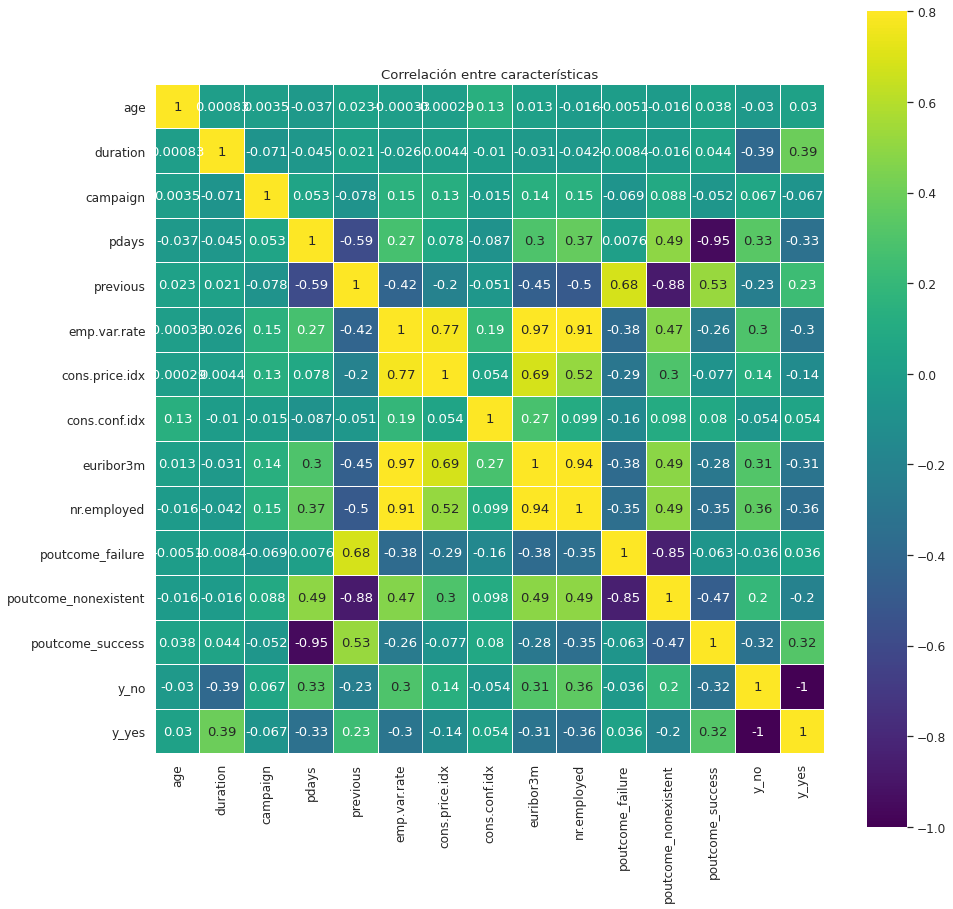

In [ ]:
# Correlación entre las variables continuas
# Se tomó el código base de la fuente [1] y se adaptó al caso

# heat map
df_with_dummies = pd.get_dummies(dataset_train.drop([col for col in categorical_variables if col not in ['y', 'poutcome']], axis=1))
corrMatrix = df_with_dummies.corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(15, 15))

sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlación entre características');

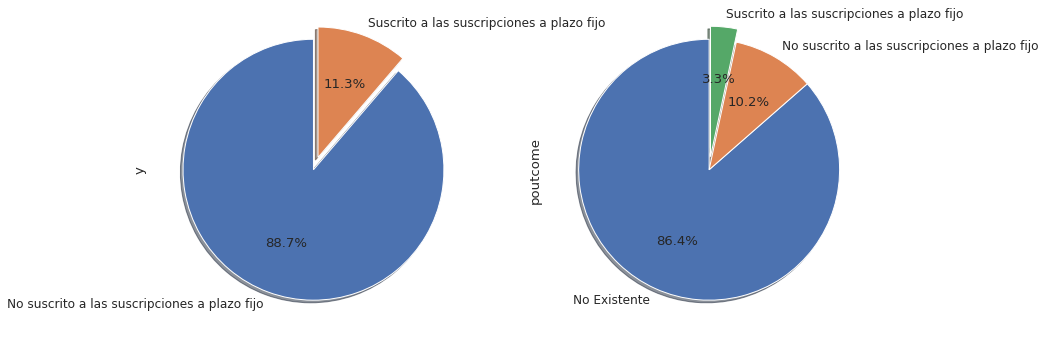

In [ ]:
"""
Descripción:
En el gráfico anterior se observa que existen relaciones fuertes entre pocas variables. 
La gradiente de colores del heat map muestra la fuerza de las relaciones, donde los colores cercanos al amarillo muestran relaciones de asociación positiva, mientras que colores más púrpuras presentan lo opuesto (correlaciones negativas).
Se observa que existe una relación, positiva, fuerte entre las variables "emp.var.rate" con "nr.employed" y "euribor3m".  

Nota: La mitad de variables del conjunto de datos son de naturaleza "categórica" y el análisis estadístico descriptivo es más reducido.

"""

fig, axs = plt.subplots(1,2, figsize=(13,6))

labels = "No suscrito a las suscripciones a plazo fijo", "Suscrito a las suscripciones a plazo fijo"
dataset_train.y.value_counts().plot.pie(explode = [0,0.1], labels = labels, 
                             ax=axs[0], autopct='%1.1f%%', shadow = True, startangle = 90)

labels = "No Existente", "No suscrito a las suscripciones a plazo fijo", "Suscrito a las suscripciones a plazo fijo"
dataset_train.poutcome.value_counts().plot.pie(explode = [0,0,0.1], labels = labels, 
                             ax=axs[1], autopct='%1.1f%%', shadow = True, startangle = 90)

plt.show()

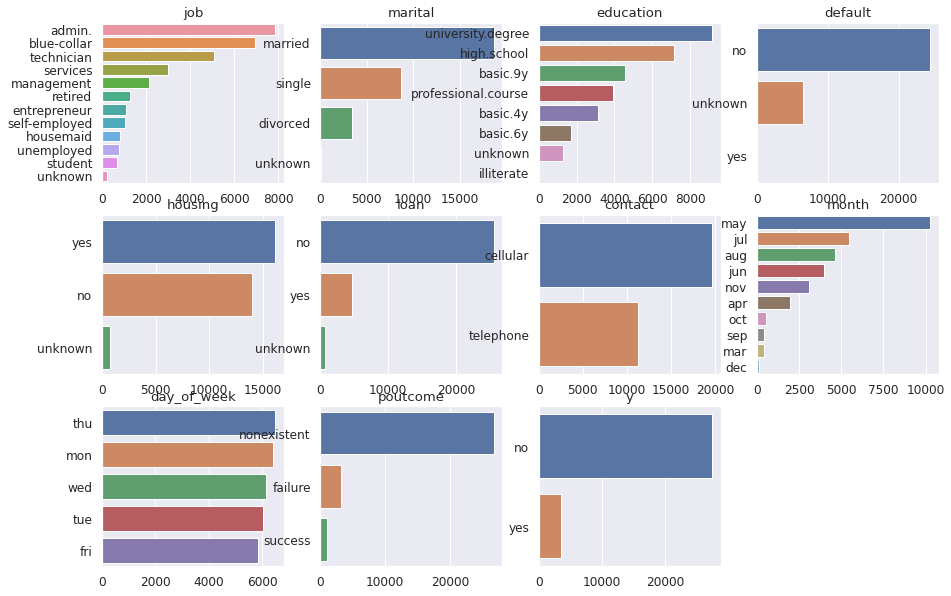

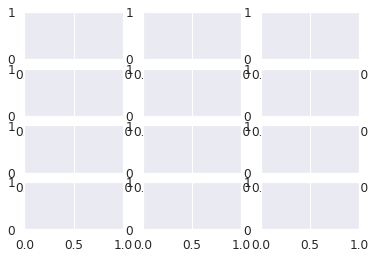

In [ ]:
"""
Análisis de las variables categóricas

Primero comenzamos el análisis exploratorio de las variables categóricas y vemos cuáles son 
las categorías y si hay algún valor faltante para estas categorías. 
Aquí, usamos sns para crear los gráficos de barras de abajo.

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'response']
"""

fig = plt.figure(figsize = (15,10))
ax = plt.subplots(4, 3)
for i, cat in enumerate(categorical_variables, 1):
    ax = fig.add_subplot(3, 4, i)
    sns.barplot(dataset_train[cat].value_counts().values, dataset_train[cat].value_counts().index, ax = ax)
    ax.title.set_text(cat)


Hay valores etiquetados como "unknown" para muchas variables en el conjunto de datos. 
Hay muchas maneras de manejar los datos que faltan. Una de ellas es descartar 
la fila pero eso llevaría a la reducción del conjunto de datos y por lo tanto 
no serviría a nuestro propósito de construir un modelo de predicción preciso y realista.


In [ ]:
pd.crosstab(dataset_train.job, dataset_train.education)

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,59,107,368,2504,1,261,4379,183
blue-collar,1719,1069,2734,653,7,340,66,342
entrepreneur,99,54,162,172,2,106,456,43
housemaid,365,56,67,130,1,43,105,35
management,69,59,125,219,0,63,1532,86
retired,446,55,111,204,3,182,209,75
self-employed,67,17,168,87,2,123,566,24
services,105,169,293,2021,0,158,129,106
student,23,9,74,273,0,32,126,125


### **3era Sección: Preprocesamiento de los datos**

Se realizaron hipótesis sobre los factores (características) individuales y su relación con la variable target. La intuición sobre el comportamiento de las variables y sus categorías nos ayudó para llevar a cabo una correcta depuración de los datos y la preparación de los datos para la modelización.

In [ ]:
#utilizamos la función para identificar cuantos registros con la etiqueta "unknown" hay
def get_unknown_colums(df):
    """
      - Funcción para obtener las columnas con el valor unknown
      - @author: grupo ML
    """
    columns_with_unknown_values = []

    for col in df.columns:
        num_entries = len(df[df[col] == 'unknown'])
        if num_entries > 0:
            columns_with_unknown_values += [col]
            print('Columna "' + col + '" tiene ' + str(num_entries) + ' entradas unknown.')
            
    if len(columns_with_unknown_values) == 0:
        print('no se encontraron columnas con unknown')
      
    return columns_with_unknown_values

In [ ]:
get_unknown_colums(dataset_train)

Columna "job" tiene 248 entradas unknown.
Columna "marital" tiene 60 entradas unknown.
Columna "education" tiene 1291 entradas unknown.
Columna "default" tiene 6431 entradas unknown.
Columna "housing" tiene 734 entradas unknown.
Columna "loan" tiene 734 entradas unknown.


['job', 'marital', 'education', 'default', 'housing', 'loan']

### Sobre la imputación de los datos faltantes ("unknown")

En este sección hemos utilizado parte de la intuición de imputación la fuente de los notebooks [2] y [3]. A su vez, también se aplican métodos de imputación utilizando estadísticos de tendencia central (moda, mediana, media).

Compartimos la presunción de que la variable "job" (empleo) está influenciada por el (nivel educativo) "education" de una persona. En ese sentido
Por lo tanto, podemos inferir "job" basado en la "education" de la persona.

Infiriendo la educación de los trabajos: De la tabulación cruzada, 
se puede ver que las personas con trabajos de gestión/administración suelen tener un un título universitario. 

Por lo tanto, donde 'job' = management and 'education' = unknown,
 podemos sustituir 'education' with 'university.degree'.  
 De manera similar, 'job' = 'services' --> 'education' = 'high.school' and 'job' = 'housemaid' --> 'education' = 'basic.4y'.

Entendiendo que los empleos catalogados como "blue collar" son básicamente trabajos manuales donde no se requiere mucha calificación es que convenimos en utilizar  las categorías más bajas de la variable nivel de educación para imputar los valores unknown en la variable "job" y colocar "blue collar".  
Infiriendo los trabajos desde la educación: 
If 'education' = 'basic.4y' or 'basic.6y' or 'basic.9y' 
then the 'job' is usually 'blue-collar'. 
Una última casuística se relaciona con el nivel educativo "formación profesional"  para imputar la categoría "technician" en la variable empleo.
If 'education' = 'professional.course', then the 'job' = 'technician'.

Asimismo, tiene sentido colocar "jubilado" en la población de adultos mayores que no registró su empleo.

Como vemos, if 'age' > 60, 
luego el 'job' is 'retired,' lo que tiene sentido.

Mientras que se imputan los valores para el empleo y el nivel educativo, 
...sabíamos que las correlaciones debían tener sentido en el mundo real. 
Si no tenían sentido en el mundo real, no reemplazábamos los valores que faltaban.

> pd.crosstab(dataset.job, dataset.education)

Como podemos ver, somos capaces de reducir el número de incógnitas y mejorar nuestro conjunto de datos.

In [ ]:
df1 = dataset_train.copy()

df1['default'] = df1.default.replace('unknown',df1.default.mode([0]))

df1.housing.replace('unknown', df1.housing.mode()[0],inplace=True)

df1['loan'] = df1.default.replace('unknown', df1.loan.mode()[0])

In [ ]:
def replace_unknown(df):
    df1 = df.copy()

    df1.loc[(df1['age']>60) & (df1['job']=='unknown'), 'job'] = 'retired'

    df1.loc[(df1['education']=='unknown') & (df1['job']=='management'), 'education'] = 'university.degree'

    df1.loc[(df1['education']=='unknown') & (df1['job']=='services'), 'education'] = 'high.school'

    df1.loc[(df1['education']=='unknown') & (df1['job']=='housemaid'), 'education'] = 'basic.4y'

    df1.loc[(df1['job'] == 'unknown') & (df1['education']=='basic.4y'), 'job'] = 'blue-collar'

    df1.loc[(df1['job'] == 'unknown') & (df1['education']=='basic.6y'), 'job'] = 'blue-collar'

    df1.loc[(df1['job'] == 'unknown') & (df1['education']=='basic.9y'), 'job'] = 'blue-collar'

    df1.loc[(df1['job']=='unknown') & (df1['education']=='professional.course'), 'job'] = 'technician'

    return df1

In [ ]:
df1 = replace_unknown(df1)

pd.crosstab(df1.job, df1.education)

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,59,107,368,2504,1,261,4379,183
blue-collar,1751,1085,2758,653,7,340,66,342
entrepreneur,99,54,162,172,2,106,456,43
housemaid,400,56,67,130,1,43,105,0
management,69,59,125,219,0,63,1618,0
retired,449,55,111,204,3,183,210,87
self-employed,67,17,168,87,2,123,566,24
services,105,169,293,2127,0,158,129,0
student,23,9,74,273,0,32,126,125


In [ ]:
from sklearn.impute import SimpleImputer

columns_with_unknown_values = get_unknown_colums(df1)

impute_missing = SimpleImputer(missing_values='unknown', strategy='most_frequent') 

df1[columns_with_unknown_values] = impute_missing.fit_transform(df1[columns_with_unknown_values])

df1[columns_with_unknown_values].head(10)

Columna "job" tiene 150 entradas unknown.
Columna "marital" tiene 60 entradas unknown.
Columna "education" tiene 1064 entradas unknown.
Columna "default" tiene 6431 entradas unknown.


,job,marital,education,default
10685,blue-collar,divorced,high.school,no
224,technician,married,basic.9y,no
29638,self-employed,single,university.degree,no
4804,technician,married,high.school,no
11614,blue-collar,single,basic.6y,no
19300,admin.,single,university.degree,no
155,blue-collar,married,basic.9y,no
40537,admin.,single,high.school,no
13240,blue-collar,divorced,basic.4y,no
22849,services,married,high.school,no


### Relación de cada variable con la duración

La duración se obtiene después de que se hace la llamada al cliente potencial, así que si el cliente objetivo nunca ha recibido llamadas esta característica no es tan útil. La razón por la que la duración está altamente correlacionada con la apertura de un depósito a plazo es que cuanto más hable el banco con un cliente objetivo, mayor será la probabilidad de que éste abra un depósito a plazo, ya que una mayor duración significa un mayor interés (compromiso) por parte del cliente potencial.


Eliminar donde la duración de la llamada fue de menos de 10 segundos


Eliminar 219 filas
[df.duration < 10/60]

> df = df.drop(df[df.duration < 10/60].index, axis = 0, inplace = False)


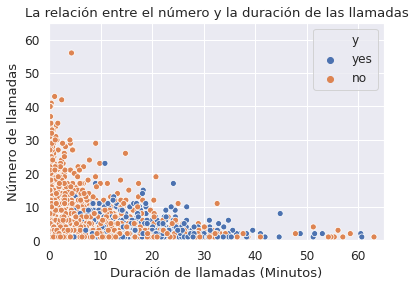

In [ ]:
df_sct = df1.copy()

df_sct['pdays'] = np.where(df_sct['pdays'] == 999, df_sct[df_sct['pdays'] < 999]['pdays'].mean(), df_sct['pdays'])

df_sct['duration'] = df_sct['duration'].apply(lambda n:n/60).round(2)

duration_campaign = sns.scatterplot(x='duration', y='campaign', data = df_sct, hue = 'y')

plt.axis([0,65,0,65])
plt.ylabel('Número de llamadas')
plt.xlabel('Duración de llamadas (Minutos)')
plt.title('La relación entre el número y la duración de las llamadas')
# Annotation
plt.show()

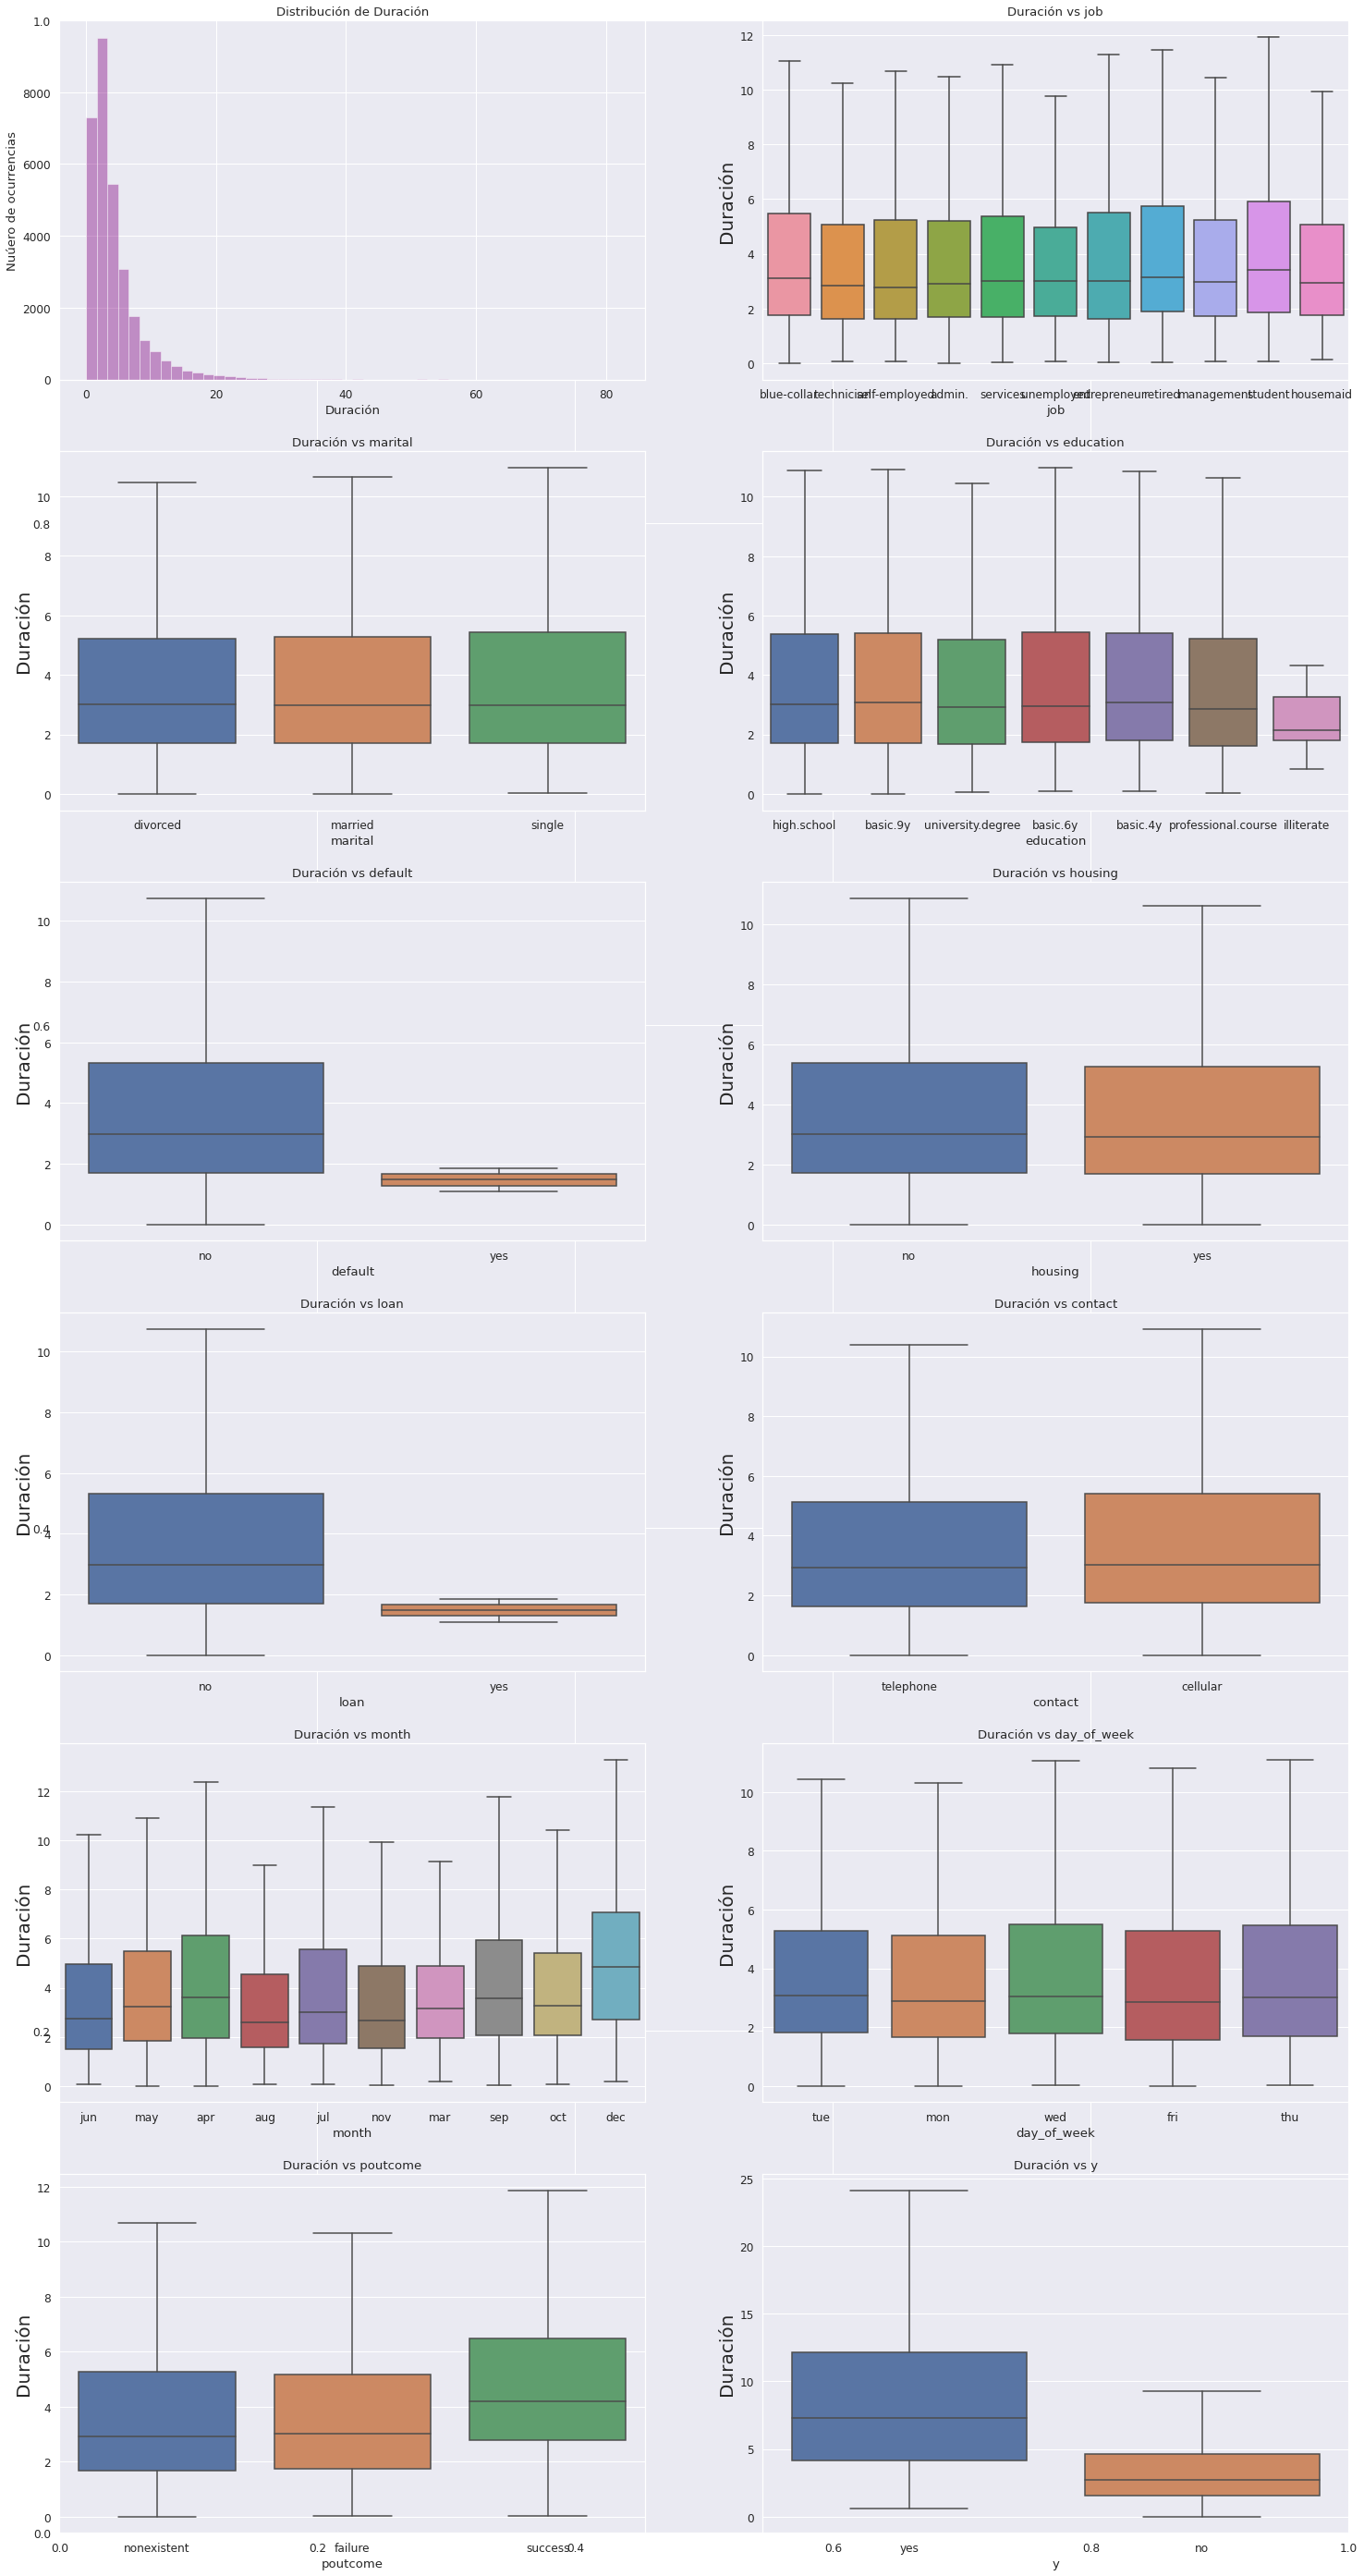

In [ ]:
##se realizarán distintas gráficas de dispersión de los cruces de las variables categóricas vs. la variable duración, que resulta ser la más importante en todos los notebooks al respecto.
#se ha utilizado y adaptado el código de la fuente [3]

fig, ax = plt.subplots(figsize=(25,50))

ax = fig.add_subplot(6, 2, 1)
sns.distplot(df_sct['duration'], color="purple", kde=False, ax = ax)
ax.title.set_text("Distribución de Duración")
ax.set_ylabel("Nuúero de ocurrencias")
ax.set_xlabel("Duración");

for i, cat in enumerate(categorical_variables, 1):
    # sns.boxplot(x, y, argument to hide outliers)
    ax = fig.add_subplot(6, 2, i+1)
    sns.boxplot(df_sct[cat], df_sct["duration"], showfliers=False, ax = ax)

    # title for the plot
    ax.title.set_text("Duración vs {}".format(cat))
    ax.set_ylabel("Duración", fontsize = 20)
    ax.set_label(cat)


Análisis:



*   La variable duración es asimétrica. Tiene una distribución sesgada, cola derecha. La mayor cantidad de registros se encuentran en los valores de menor duración. 
*   Job: En relación con el empleo, parece no haber mucha diferencia. En la categoría estudiantes, pareciera haber una mayor duración de las llamadas. Sin embargo, se debería realizar una prueba estadística (diferencia de medias) para determinar si es así.
*    Education: No existe mucha diferencia salvo con la categoría de "illiterate" (sin educación), lo cual tiene sentido con la realidad.
*   Marital: El estado civil no tiene mayor relación con la duración de la llamada.
*  Default: Se puede ver que tiene un crédito en default (no ha pagado) no está dispuesto a escuchar las llamadas de marketing del banco. Esto también tiene sentido pues, el número de llamadas cuando uno es deudor del banco crece de forma muy drástica y llega a hartar.
*  Housing: Los préstamos para vivienda no tienen relación con la duración de la llamada.
*  Loan: Las personas que no tienen préstamos se quedan más tiempo en las llamadas
*  Contact: Parece que las llamadas en los teléfonos celulares duraron más tiempo que las que fueron contestadas en el teléfono fijo.
*  Month: Al parecer, en los meses de diciembre y de abril, las llamadas tienden a durar un poco más. Esto se puede deber al lanzamiento de campañas por fiestas y quizás al pago de las utilidades y bonos.
*  Day_of_week: No hay mayor diferencia entre los días de la semana.


### Relacionar la variable objetivo (y) con variables categóricas

Lista de la frecuencia relativa normalizada de la clase de objetivo por categoría.

Distribución normalizada de cada clase por característica y diferencia trazada entre las frecuencias positivas y negativas. Los valores positivos implican que esta categoría favorece a los clientes que se suscriben y los valores negativos a las categorías que favorecen la no compra del producto.

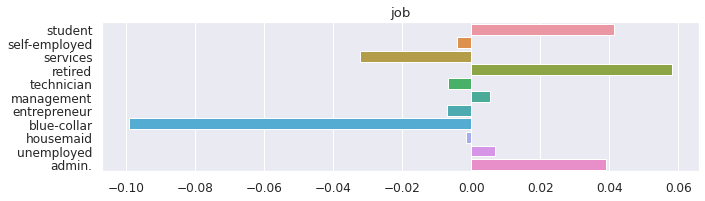

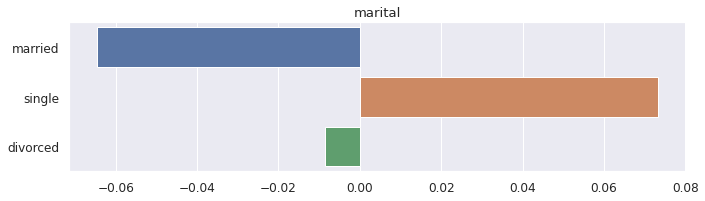

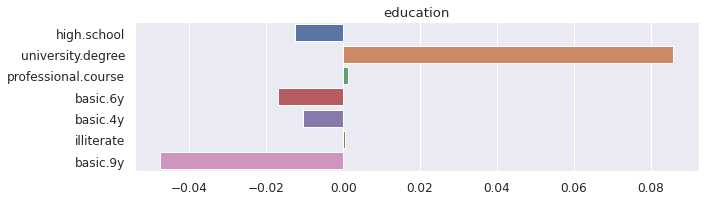

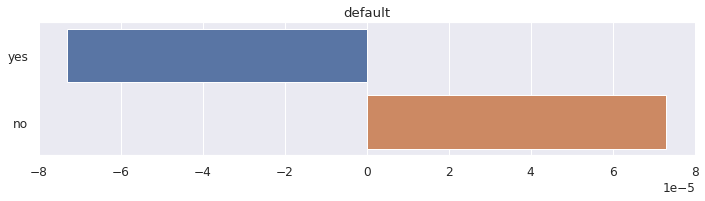

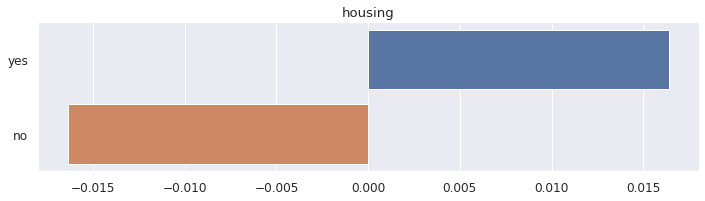

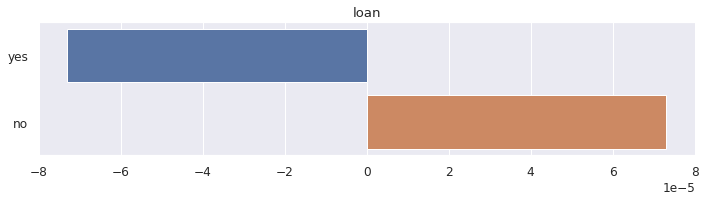

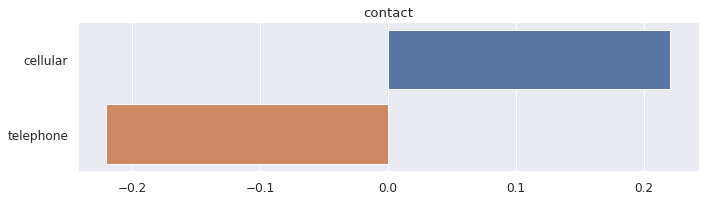

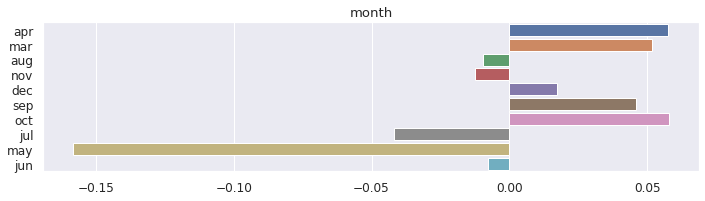

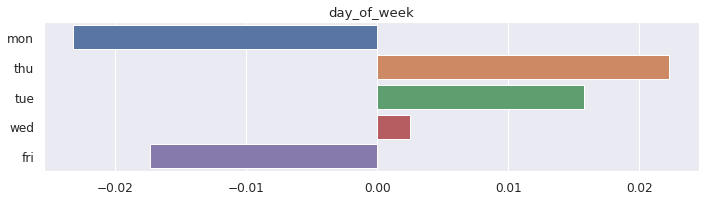

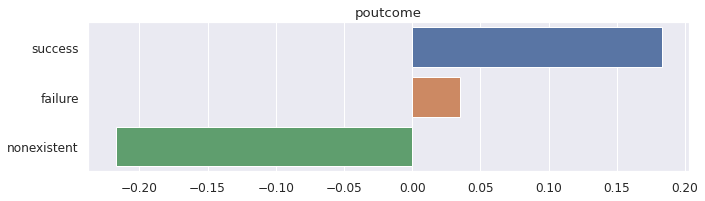

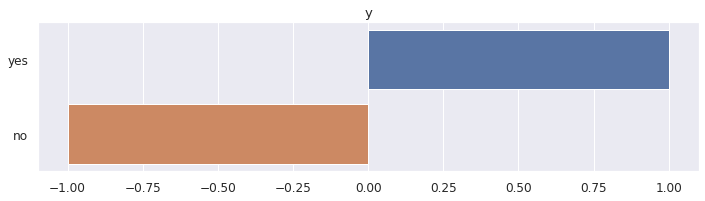

In [ ]:
#se ha utilizado y adaptado el código de la fuente [3]
for col in categorical_variables:
    plt.figure(figsize=(10,3))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = df_sct.loc[df_sct.y.values == 'yes', col].value_counts() 
    neg_counts = df_sct.loc[df_sct.y.values == 'no', col].value_counts()
    
    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (df_sct.y.values == 'yes').sum()
    freq_neg = (df_sct.y.values == 'no').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()
    
    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()

### Perspectivas

Aunque estas puntuaciones dan una visión directa y precisa de los datos con respecto a la variable objetivo (y),  no podemos confiar plenamente en estas puntuaciones ya que muchos de los valores están por debajo de 0,1.

*  Job: Los estudiantes, los jubilados y los administradores son más propensos a suscribirse a depósitos a plazo que otras profesiones, 
pero su puntuación normalizada es baja. Es improbable que la gente de cuello de buey se suscriba.
*  Education: Las personas con título universitario son más propensas pero con una puntuación normalizada baja.
*  Marital: Las personas solteras son más propensas pero con una puntuación normalizada baja.
*  Default: Las personas que no tienen ningún incumplimiento son más propensas a suscribirse a los depósitos a plazo.
*  Housing: No hay datos útiles.
*  Loan: La gente que no tiene préstamos es probable, pero con una puntuación menos normalizada.
*  Contact: Las personas que llaman por teléfono celular son muy propensas a suscribirse a depósitos a plazo.
*  Month: Llamar en el mes de mayo hace muy poco probable que el usuario se suscriba.
*  Day_of_week: Se muestra el mismo patrón a favor de la relación con la duración.

### **4ta Sección: Procesamiento**

In [ ]:
to_remove_column = set([])#set(["pdias"])

def preprocess_dataset(dataset):
  preprocessed_dataset = dataset.copy()
  preprocessed_dataset.drop_duplicates(inplace=True)

  preprocessed_dataset['pdays'] = np.where(preprocessed_dataset['pdays'] == 999, 
                                           preprocessed_dataset[preprocessed_dataset['pdays'] < 999]['pdays'].mean(), 
                                           preprocessed_dataset['pdays'])

  preprocessed_dataset['duration'] = preprocessed_dataset['duration'].apply(lambda n:n/60).round(2)

  preprocessed_dataset.drop(preprocessed_dataset[preprocessed_dataset.duration < 10/60].index, axis = 0, inplace = True)

  

  if to_remove_column.issubset(set(preprocessed_dataset.columns)):
    preprocessed_dataset.drop(to_remove_column, axis=1, inplace=True)

  preprocessed_dataset["month"].replace(to_replace =["jan"], value=0,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["feb"], value=1,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["mar"], value=2,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["apr"], value=3,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["may"], value=4,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["jun"], value=5,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["jul"], value=6,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["aug"], value=7,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["sep"], value=8,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["oct"], value=9,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["nov"], value=10,inplace =True)
  preprocessed_dataset["month"].replace(to_replace =["dec"], value=11,inplace =True)

  preprocessed_dataset["day_of_week"].replace(to_replace =["mon"], value=0,inplace =True)
  preprocessed_dataset["day_of_week"].replace(to_replace =["tue"], value=1,inplace =True)
  preprocessed_dataset["day_of_week"].replace(to_replace =["wed"], value=2,inplace =True)
  preprocessed_dataset["day_of_week"].replace(to_replace =["thu"], value=3,inplace =True)
  preprocessed_dataset["day_of_week"].replace(to_replace =["fri"], value=4,inplace =True)
  preprocessed_dataset["day_of_week"].replace(to_replace =["sat"], value=4,inplace =True)
  preprocessed_dataset["day_of_week"].replace(to_replace =["sun"], value=4,inplace =True)

  preprocessed_dataset["education"] = preprocessed_dataset["education"].replace(
        regex=[r'^basic.*$', 'illiterate'], value='basic'
  ).replace(regex=['professional.course', 'university.degree'], value='superior')

  educacion_dummies = pd.get_dummies(preprocessed_dataset["education"], prefix="education").iloc[:,1:]
  preprocessed_dataset = pd.concat([preprocessed_dataset, educacion_dummies], axis=1)

  if "education" in preprocessed_dataset:
    preprocessed_dataset.drop(["education"], axis=1, inplace=True)

  Trabajo_dummies = pd.get_dummies(preprocessed_dataset["job"], prefix="job").iloc[:,1:]
  preprocessed_dataset = pd.concat([preprocessed_dataset, Trabajo_dummies], axis=1)

  if "job" in preprocessed_dataset:
    preprocessed_dataset.drop(["job"], axis=1, inplace=True)    

  Estadocivil_dummies = pd.get_dummies(preprocessed_dataset["marital"], prefix="marital").iloc[:,1:]
  preprocessed_dataset = pd.concat([preprocessed_dataset, Estadocivil_dummies], axis=1)

  if "marital" in preprocessed_dataset:
    preprocessed_dataset.drop(["marital"], axis=1, inplace=True)


  label_encoder = LabelEncoder()

  for column in preprocessed_dataset.columns:
    if not pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
      preprocessed_dataset[column] = label_encoder.fit_transform(preprocessed_dataset[column].astype(str))

      print("Para la columna '{}', la codificación fue: {}".format(column, dict(enumerate(label_encoder.classes_))))
  
  return preprocessed_dataset

In [ ]:
#Transformamos los datos a valores numéricos
preprocessed_dataset = preprocess_dataset(df1)

print("\n >", "-"*10, "Tipo de datos", "-"*10, "< \n")
preprocessed_dataset.dtypes

Para la columna 'default', la codificación fue: {0: 'no', 1: 'yes'}
Para la columna 'housing', la codificación fue: {0: 'no', 1: 'yes'}
Para la columna 'loan', la codificación fue: {0: 'no', 1: 'yes'}
Para la columna 'contact', la codificación fue: {0: 'cellular', 1: 'telephone'}
Para la columna 'poutcome', la codificación fue: {0: 'failure', 1: 'nonexistent', 2: 'success'}
Para la columna 'y', la codificación fue: {0: 'no', 1: 'yes'}

 > ---------- Tipo de datos ---------- < 



age                        int64
default                    int64
housing                    int64
loan                       int64
contact                    int64
month                      int64
day_of_week                int64
duration                 float64
campaign                   int64
pdays                    float64
previous                   int64
poutcome                   int64
emp.var.rate             float64
cons.price.idx           float64
cons.conf.idx            float64
euribor3m                float64
nr.employed              float64
y                          int64
education_high.school      uint8
education_superior         uint8
job_blue-collar            uint8
job_entrepreneur           uint8
job_housemaid              uint8
job_management             uint8
job_retired                uint8
job_self-employed          uint8
job_services               uint8
job_student                uint8
job_technician             uint8
job_unemployed             uint8
marital_ma

In [ ]:
preprocessed_dataset.head()

,age,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_high.school,education_superior,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single
10685,52,0,0,0,1,5,1,11.27,2,5.99207,0,1,1.4,94.465,-41.8,4.961,5228.1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
224,40,0,0,0,1,4,0,2.80,1,5.99207,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
29638,28,0,1,0,0,3,0,3.12,1,5.99207,0,1,-1.8,93.075,-47.1,1.405,5099.1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4804,52,0,0,0,1,4,2,1.13,1,5.99207,0,1,1.1,93.994,-36.4,4.858,5191.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
11614,35,0,0,0,1,5,4,1.35,2,5.99207,0,1,1.4,94.465,-41.8,4.959,5228.1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


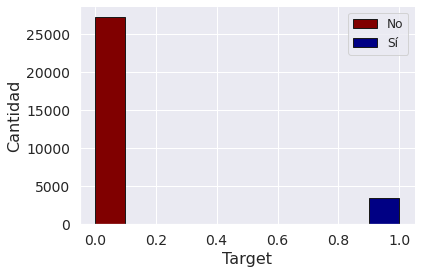

In [ ]:
from matplotlib.patches import Rectangle

N, bins, patches = plt.hist(preprocessed_dataset["y"], ec="k")

cmap = plt.get_cmap('jet')
low = cmap(1.1)
high = cmap(1)


for i in range(0,4):
    patches[i].set_facecolor(low)
for i in range(4,10):
    patches[i].set_facecolor(high)

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low,high]]

labels= ["No","Sí"]
plt.legend(handles, labels)


plt.xlabel("Target", fontsize=16)  
plt.ylabel("Cantidad", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

In [ ]:
def create_bins(df, column, bins_dict):
  bins_list = bins_dict["bins_list"]
  bins_number = bins_dict["bins_number"]

  if (bins_list):
    data_for_bins = pd.cut(df[column], bins=bins_list, precision=0, duplicates="drop")

  else:
    data_for_bins = df[column]

    min_value = data_for_bins.min()
    max_value = data_for_bins.max()

    repetitions_of_min_value = len(data_for_bins[data_for_bins == min_value])
    repetitions_of_max_value = len(data_for_bins[data_for_bins == max_value])

    if repetitions_of_min_value > 1:
      #Si el valor mínimo se repite entonces agregamos un valor mínimo falso para balancear mejor los quantiles
      data_for_bins = data_for_bins.append(pd.Series([min_value - 1]), ignore_index=True)

    if repetitions_of_max_value > 1:
      #Si el valor máximo se repite entonces agregamos un valor máximo falso para balancear mejor los quantiles
      data_for_bins = data_for_bins.append(pd.Series([max_value + 1]), ignore_index=True)
    
    #Se usa duplicates="drop" por si los límites de los bins se repiten. No sucederá este caso para el primer y último bin 
    quantiles = pd.qcut(data_for_bins, q=bins_number, precision=0, duplicates="drop")
    
    data_for_bins = quantiles

    if repetitions_of_max_value > 1:
      #Eliminamos el valor máximo que introducimos
      data_for_bins = data_for_bins[:-1]
    
    if repetitions_of_min_value > 1:
      #Eliminamos el valor máximo que introducimos
      data_for_bins = data_for_bins[:-1]

  dictionary_of_intervals = dict()

  for index, interval in enumerate(data_for_bins.cat.categories):
    dictionary_of_intervals[interval] = int(index)
    
  df.reset_index(drop=True, inplace=True)

  bins_column = "Bins_for_" + column

  #df.drop([column], axis=1, inplace=True)

  df[bins_column + "_index"] = data_for_bins

  df.replace({bins_column + "_index": dictionary_of_intervals}, inplace=True)
  print("Bins for "+ column +" Created")

In [ ]:
bins_dict = {
    "Edad": {"bins_number": 0, "bins_list": [0,20,30,40,50,70,100]},
	  "Duracion": {"bins_number": 5, "bins_list": []},
	  "Llamadas": {"bins_number": 4, "bins_list": []},
	  #"tasaVarEmp": {"bins_number": 5, "bins_list": []},
	 # "indicador consumidor precio": {"bins_number": 5, "bins_list": []},
	  #"indicador confianza consumidor": {"bins_number": 5, "bins_list": []},
	  "indicador macro": {"bins_number": 5, "bins_list": []}
	  #"ind. Cuartil emp": {"bins_number": 5, "bins_list": []}
}

In [ ]:
for column, bins_list in bins_dict.items():
  create_bins(preprocessed_dataset, column, bins_list)

Bins for Edad Created
Bins for Duracion Created
Bins for Llamadas Created
Bins for indicador macro Created


In [ ]:
preprocessed_dataset.head()

,age,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_high.school,education_superior,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single
10685,52,0,0,0,1,5,1,11.27,2,5.99207,0,1,1.4,94.465,-41.8,4.961,5228.1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
224,40,0,0,0,1,4,0,2.80,1,5.99207,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
29638,28,0,1,0,0,3,0,3.12,1,5.99207,0,1,-1.8,93.075,-47.1,1.405,5099.1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4804,52,0,0,0,1,4,2,1.13,1,5.99207,0,1,1.1,93.994,-36.4,4.858,5191.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
11614,35,0,0,0,1,5,4,1.35,2,5.99207,0,1,1.4,94.465,-41.8,4.959,5228.1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


## **5ta Sección: Modelamiento**

In [ ]:
df2 = dataset_test.copy()

In [ ]:
df2 = replace_unknown(df2)

In [ ]:
for u in get_unknown_colums(df2):
  df2[u].replace('unknown', df1[u].mode()[0], inplace=True)

Columna "job" tiene 48 entradas unknown.
Columna "marital" tiene 20 entradas unknown.
Columna "education" tiene 352 entradas unknown.
Columna "default" tiene 2166 entradas unknown.
Columna "housing" tiene 256 entradas unknown.
Columna "loan" tiene 256 entradas unknown.


In [ ]:
#Transformamos los datos a valores numéricos
preprocessed_dataset_test = preprocess_dataset(df2)

print("\n >", "-"*10, "Tipo de datos", "-"*10, "< \n")
preprocessed_dataset_test.dtypes

Para la columna 'default', la codificación fue: {0: 'no', 1: 'yes'}
Para la columna 'housing', la codificación fue: {0: 'no', 1: 'yes'}
Para la columna 'loan', la codificación fue: {0: 'no', 1: 'yes'}
Para la columna 'contact', la codificación fue: {0: 'cellular', 1: 'telephone'}
Para la columna 'poutcome', la codificación fue: {0: 'failure', 1: 'nonexistent', 2: 'success'}
Para la columna 'y', la codificación fue: {0: 'no', 1: 'yes'}

 > ---------- Tipo de datos ---------- < 



age                        int64
default                    int64
housing                    int64
loan                       int64
contact                    int64
month                      int64
day_of_week                int64
duration                 float64
campaign                   int64
pdays                    float64
previous                   int64
poutcome                   int64
emp.var.rate             float64
cons.price.idx           float64
cons.conf.idx            float64
euribor3m                float64
nr.employed              float64
y                          int64
education_high.school      uint8
education_superior         uint8
job_blue-collar            uint8
job_entrepreneur           uint8
job_housemaid              uint8
job_management             uint8
job_retired                uint8
job_self-employed          uint8
job_services               uint8
job_student                uint8
job_technician             uint8
job_unemployed             uint8
marital_ma

In [ ]:
preprocessed_dataset_test.head()

,age,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_high.school,education_superior,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single
15500,39,0,1,0,0,6,4,10.58,3,6.081579,0,1,1.4,93.918,-42.7,4.957,5228.1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
29034,55,0,1,0,0,3,4,4.13,2,6.081579,0,1,-1.8,93.075,-47.1,1.405,5099.1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
11199,39,0,0,0,1,5,3,3.45,1,6.081579,0,1,1.4,94.465,-41.8,4.961,5228.1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
22247,56,0,1,0,0,7,3,2.93,7,6.081579,0,1,1.4,93.444,-36.1,4.963,5228.1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
27180,49,0,1,0,0,10,4,4.52,1,6.081579,0,1,-0.1,93.200,-42.0,4.021,5195.8,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
for column, bins_list in bins_dict.items():
  create_bins(preprocessed_dataset_test, column, bins_list)

Bins for Edad Created
Bins for Duracion Created
Bins for Llamadas Created
Bins for indicador macro Created


## Model Parameters


In [ ]:
x_train = preprocessed_dataset.drop(['y'], axis = 1).values
y_train = preprocessed_dataset['y'].values

x_test = preprocessed_dataset_test.drop(['y'], axis = 1).values
y_test = preprocessed_dataset_test['y'].values

In [ ]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.legend(loc=4)
    plt.show()

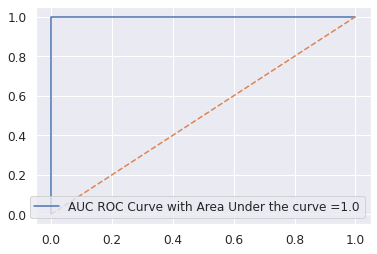

In [ ]:
generate_auc_roc_curve(rf, x_test)

In [ ]:
from sklearn import metrics

def print_binary_confusion_matrix(y_true, y_pred):
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
  TN = confusion_matrix[0,0]
  FN = confusion_matrix[1,0]
  FP = confusion_matrix[0,1]
  TP = confusion_matrix[1,1]
  exactitud = (TP + TN)/ (TP + TN + FP + FN)
  precision = TP/ (TP + FP)
  exhaustividad = TP/ (TP + FN)

  print ('              +-----------------+')
  print ('              |   Predicción    |')
  print ('              +-----------------+')
  print ('              |    +   |    -   |')
  print ('+-------+-----+--------+--------+')
  print ('| Valor |  +  |  {:5d} |  {:5d} |'.format(TP, FN) )
  print ('| real  +-----+--------+--------+')
  print ('|       |  -  |  {:5d} |  {:5d} |'.format(FP, TN) )
  print ('+-------+-----+--------+--------+')
  print('Exactitud     : {:.3f}'.format(exactitud))
  print('Precisión     : {:.3f}'.format(precision))
  print('Exhaustividad : {:.3f}'.format(exhaustividad))
  print()

In [ ]:
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(y_train, rf.predict(x_train))

print('Conjunto de prueba :')
print_binary_confusion_matrix(y_test, rf.predict(x_test))

Conjunto de entrenamiento + validación:
              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   3482 |      0 |
| real  +-----+--------+--------+
|       |  -  |      0 |  27190 |
+-------+-----+--------+--------+
Exactitud     : 1.000
Precisión     : 1.000
Exhaustividad : 1.000

Conjunto de prueba :
              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   3482 |      0 |
| real  +-----+--------+--------+
|       |  -  |      0 |  27179 |
+-------+-----+--------+--------+
Exactitud     : 1.000
Precisión     : 1.000
Exhaustividad : 1.000



In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

clf1 = RandomForestClassifier(n_estimators =  100,  n_jobs=-1, random_state = 5)
clf2 = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, random_state = 5)
clf3 = XGBClassifier(nthreads = -1, random_state = 5)
clf4 = AdaBoostClassifier(random_state = 5)

classifiers = [('RF', clf1), ('GB', clf2), ('XB', clf3), ('AB', clf4)]

for clf_name, clf in classifiers:
    clf.fit(x_train, y_train)
    print("{:3} classifier:\n \
        \ttrain accuracy: {:.2f}\n \
        \ttest accuracy: {:.2f}"
        .format(clf_name, 
                clf.score(x_train, y_train), 
                clf.score(x_test, y_test)))

RF  classifier:
         	train accuracy: 1.00
         	test accuracy: 0.91
GB  classifier:
         	train accuracy: 0.92
         	test accuracy: 0.92
XB  classifier:
         	train accuracy: 0.92
         	test accuracy: 0.92
AB  classifier:
         	train accuracy: 0.91
         	test accuracy: 0.91


In [ ]:
TC_parameters = {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 100}
RF_pamameters = {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 500}
XGC_pamameters =  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'scale_pos_weight': 7.903}

LGBM_parameters = {
    'bagging_freq': 5, #5
    'bagging_fraction': 0.4, #0.4
    'boost_from_average':'false',
    'min_child_samples': 30,
    'boost': 'gbdt',
    'feature_fraction': 0.5, #0.05
    'learning_rate': 0.01, #0.01
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80, #80
    'min_sum_hessian_in_leaf': 10, #10
    'num_leaves': 32, #13
    'num_threads': 16, 
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    "is_unbalance":True,
    "random_state":1234,
}

In [ ]:
def run_model(train_df, test_df, target_col, LGBM_parameters):
  features  = list(train_df.columns)
  features.remove(target_col)
  target = train_df[target_col]
  folds  = StratifiedKFold(n_splits=5, shuffle=True, random_state=44000)
  oof    = np.zeros(len(train_df))
  predictions = np.zeros(len(test_df))
  feature_importance_df = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
      print("Fold {}".format(fold_))
      trn_data = lgbm.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
      val_data = lgbm.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

      num_round = 10000
      clf = lgbm.train(LGBM_parameters, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
      oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
      
      fold_importance_df = pd.DataFrame()
      fold_importance_df["Feature"] = features
      fold_importance_df["importance"] = clf.feature_importance()
      fold_importance_df["fold"] = fold_ + 1
      feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
      
      predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

  print("\n CV score: {:<8.5f}".format(roc_auc_score(target, oof)))   
  return predictions, feature_importance_df

In [ ]:
train_df = preprocessed_dataset.copy()
test_df  = preprocessed_dataset_test.copy()

predictions, fi_df = run_model(train_df, test_df, "Target", LGBM_parameters) # 0.94983 

Fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.963855	valid_1's auc: 0.950484
Early stopping, best iteration is:
[807]	training's auc: 0.961502	valid_1's auc: 0.950763
Fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.96326	valid_1's auc: 0.953173
Early stopping, best iteration is:
[897]	training's auc: 0.962106	valid_1's auc: 0.953383
Fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.964612	valid_1's auc: 0.946738
Early stopping, best iteration is:
[870]	training's auc: 0.963036	valid_1's auc: 0.946973
Fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.963485	valid_1's auc: 0.950411
[2000]	training's auc: 0.971296	valid_1's auc: 0.949945
Early stopping, best iteration is:
[1046]	training's auc: 0.964023	valid_1's auc: 0.950579
Fold 4
Training until validation scores don't improve for 1000 rounds.
[1000

In [ ]:
def features_plot(feature_importance_df):
  cols = (feature_importance_df[["Feature", "importance"]]
          .groupby("Feature")
          .mean()
          .sort_values(by="importance", ascending=False)[:150].index)
  best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

  plt.figure(figsize=(14,28))
  sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
  plt.title('Features importance (averaged/folds)')
  plt.tight_layout()

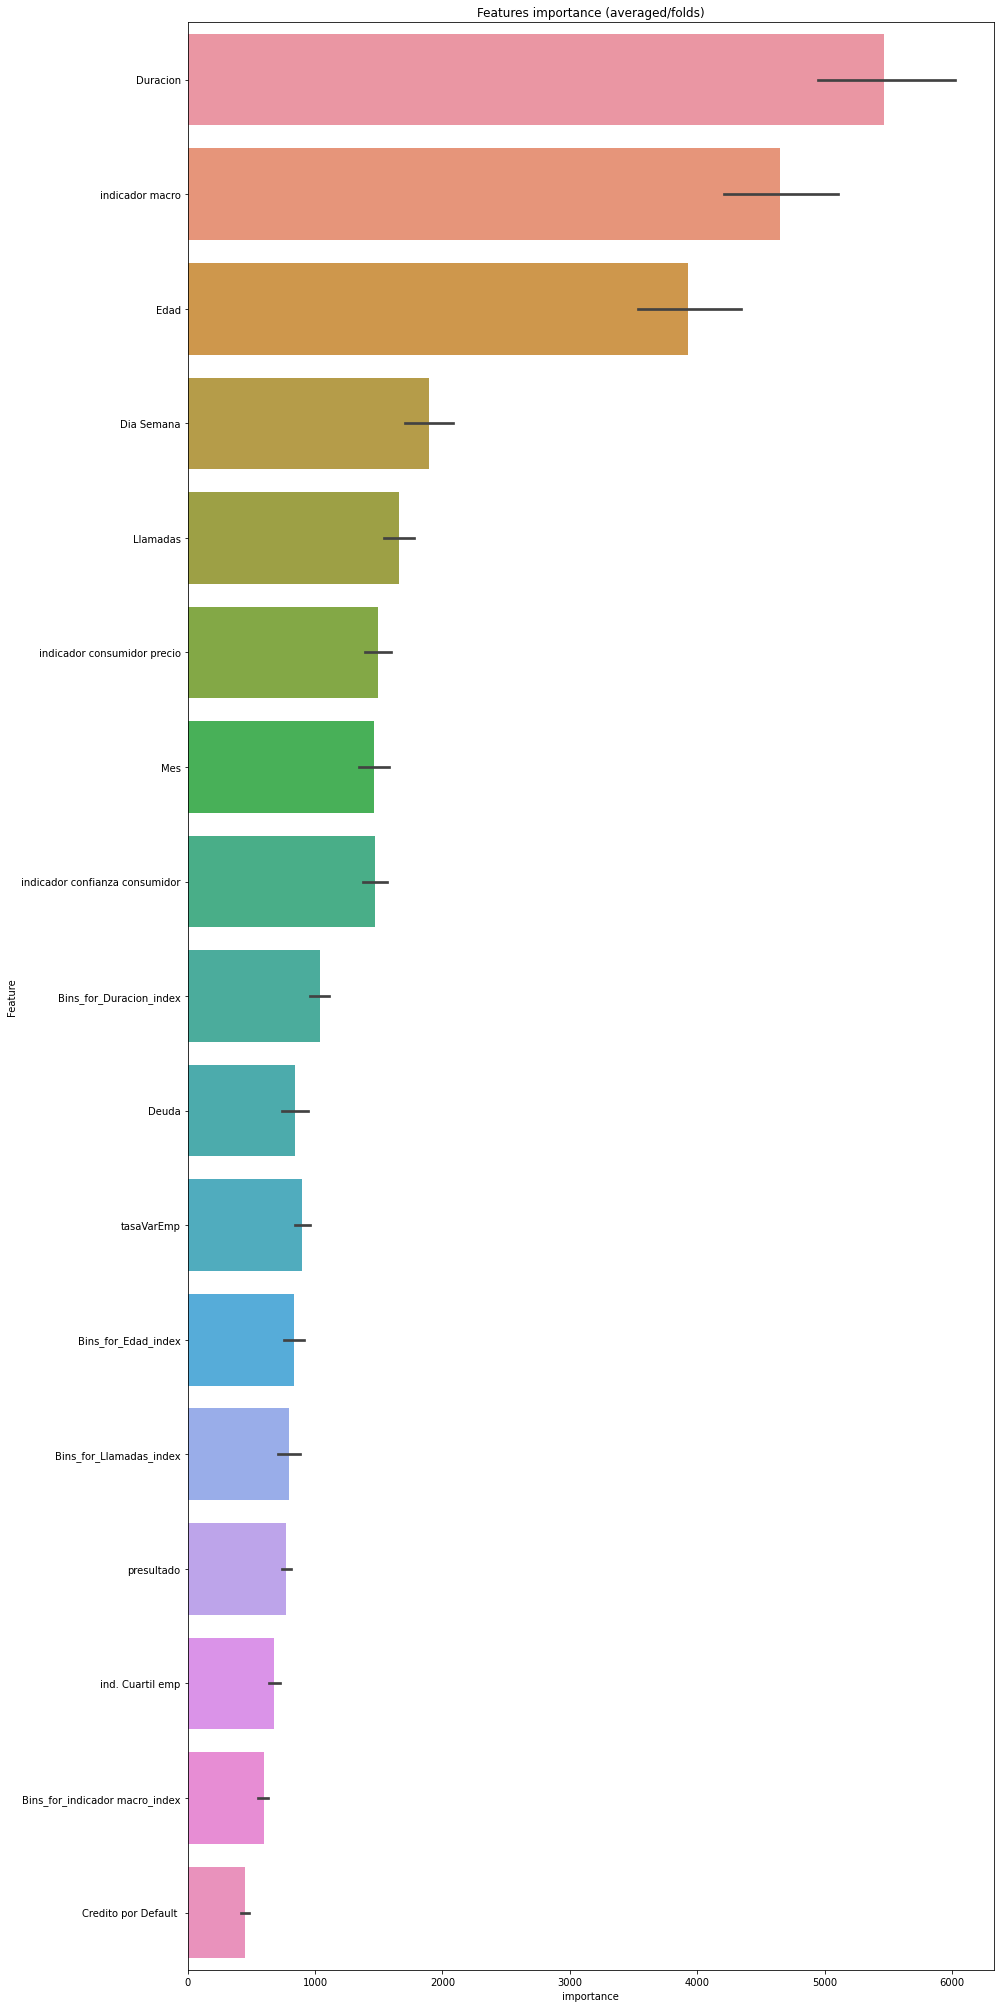

In [ ]:
features_plot(fi_df)

# Generate Submission

In [ ]:
submission = pd.DataFrame({'ID':dataset_test.ID, 'Target':predictions})

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
#files.download('submission.csv')